<a href="https://colab.research.google.com/github/st3vejobs/DATA-604/blob/main/final_project/DATA_604_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 604 Final Project

# Shane Hylton

### 17 July 2022

# Table of contents
1. [Abstract](#abstract)
  1. [Research Questions](#quest)
2. [Part I](#parti)
  1. [Data Wrangling](#wrangle)
  2. [Linear Regression](#linreg)
    1. [Multiple Regression](#multreg)
    2. [Univariate Model](#tarpt)
    3. [Analysis](#analysis)
    4. [Summary of Two Models](#twomod)
3. [Part II](#partii)
    1. [K-Nearest Neighbors](#knn)
    2. [Pass Catcher or Running Back?](#pcc)
    3. [KNN Fit Results](#result)
4. [Conclusion](#conclusion)

## Abstract<a name="abstract"></a>


### Research Question 

### Flow Chart

![image](https://github.com/st3vejobs/DATA-604/blob/main/final_project/terminal_flow.png?raw=true)


This model can be viewed somewhat similarly to the SIR model for tracking disease spread. Over time, the number of vehicles in each terminal's queue will change, and they will leave the system fully refueled and recovered.

The three different statuses I will use for the model are Driving, Waiting, and Fueled. For simplicity, I omitted driving from the flow chart. 

In [124]:
%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

from modsim import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns


from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

np.random.seed(34)

ERROR:root:The 'ast_node_interactivity' trait of a Shell instance expected any of ['all', 'last', 'last_expr', 'none'], not the str 'last_expr_or_assign'.


[SimPy](https://simpy.readthedocs.io/en/latest/simpy_intro/process_interaction.html) will be used to conduct the discrete event simulation.

In [122]:
!pip install simpy
import simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Data Source

This data is sourced from a client, and all PII has been removed from the dataset. I used Excel to clean and rename the data, and I uploaded the result to Github. 

It is important to note that the time values being presented are a decimal representation of one day. 

$$0.04 \approx 1 \  hour, 1.00 = 1 \ day.$$

All time values will be converted to integer values for the corresponding hour that the event occurs within.

In [107]:
data = pd.read_csv('https://raw.githubusercontent.com/st3vejobs/DATA-604/main/final_project/terminal_data.csv')

data.head()

data = data.rename(columns = {"Start_time_time": "time","Start_time_decimal": "decimal_time", "ExceptionDuration":"duration",
                              "Decimal_Duration":"decimal_duration","Terminal":"terminal"})
trim = data.drop(data.columns[[5]],axis = 1)

trim.head()

trim = trim.sort_values(by = 'decimal_time')
trim.head()

time_hr = 24 * trim['decimal_time']
duration_hr = 24 * trim['decimal_duration']

trim['time_hr'] = time_hr
trim['duration_hr'] = duration_hr
trim = trim.set_index(np.arange(len(trim)))
trim_long = trim
trim = trim.drop(trim[['time','decimal_time','duration','decimal_duration']],axis = 1)
trim.head()
trim_long

,time,decimal_time,duration,decimal_duration,terminal,time_hr,duration_hr
0,0:09,0.006250,1:04,0.045045,G,0.150000,1.081087
1,0:29,0.020139,1:15,0.052705,D,0.483334,1.264927
2,0:53,0.036806,1:17,0.053535,C,0.883334,1.284830
3,1:34,0.065278,1:14,0.051683,C,1.566667,1.240399
4,1:49,0.075694,1:09,0.047988,D,1.816666,1.151717
...,...,...,...,...,...,...,...
394,23:32,0.980556,1:10,0.048706,A,23.533334,1.168944
395,23:33,0.981250,1:18,0.054338,C,23.550000,1.304105
396,23:37,0.984028,1:28,0.061374,C,23.616667,1.472978
397,23:52,0.994444,1:14,0.051735,G,23.866666,1.241652


First, I will make a simpler queue model with one queue for the ten different terminals. 

![single](https://github.com/st3vejobs/DATA-604/blob/main/final_project/single_queue.png?raw=true)

Because the vehicles enter the queue at different times, I will need to model the arrival frequency. 

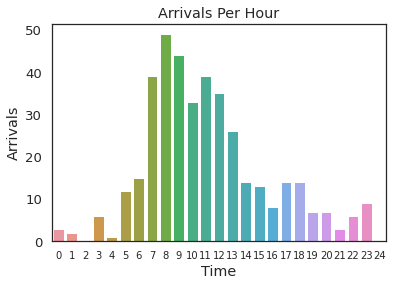

In [93]:
def pop_hour(df,hour):
  pop = df.apply(lambda df : True
                 if df['time_hr'] >= float(hour) and df['time_hr'] < float(int(hour + 1)) else False, axis = 1)
  num_rows = len(pop[pop == True].index)
  return num_rows

arrivals = DataFrame(columns = ['hour', 'arrivals'])
for i in range(0,25):
  arr = DataFrame([[i, pop_hour(trim,i)]], columns = ['hour','arrivals'])
  arrivals = pd.concat([arrivals,arr])

arrivals.set_index(arrivals['hour'], inplace = True)
#arrivals = arrivals.drop(arrivals[['hour']], axis = 1)
arrivals

arr = sns.barplot(x = 'hour',y = 'arrivals', data = arrivals)
arr.set(title = 'Arrivals Per Hour',xlabel = 'Time', ylabel = 'Arrivals')
arr.set_xticklabels(arr.get_xticklabels(), fontsize = 10)

plt.show()

#sns.kdeplot(data = arrivals['arrivals'])
#plt.show()

The distribution of arrivals is right-skewed. Smoothed, this resembles a Poisson distribution, with some variation.

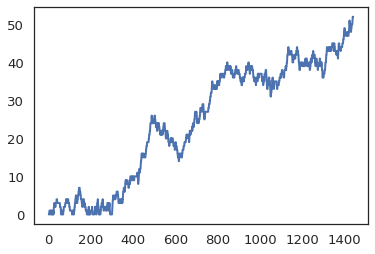

In [258]:
def create_system(lam,mu):
  return System(lam = lam, mu = mu, duration = 24 * 60) ## duration in minutes

mu = 10 / 60 * np.mean(trim_long['duration_hr']) # fuel rate per minute (10 Fuel Terminals)
lam = (np.mean(arrivals['arrivals'])/60) # arrivals per minute
system = create_system(lam,mu)
system

def update_func(waiting,t,system):
  if waiting > 0:
    if flip(system.mu):
      waiting -= 1
  if flip(system.lam):
    waiting += 1
  return waiting

def run_simulation(system,update_func):
  waiting = 0
  result = TimeSeries()
  result[0] = waiting

  for t in linrange(0,system.duration):
    waiting = update_func(waiting,t,system)
    result[t + 1] = waiting
  return result

result = run_simulation(system,update_func)
plot(result)


def compute_littles_law(result,system):
  L = result.mean()
  W = L / system.lam
  return L, W

#compute_littles_law(result,system)

Similar to attempting to get gasoline at Costco, the line just gets longer and longer. 

In [259]:
def sweep_lam(lam_array, mu, update_func):
  sweep = SweepSeries()

  for lam in lam_array:
    system = create_system(lam,mu)
    result = run_simulation(system,update_func)
    L,W = compute_littles_law(result, system)
    sweep[lam] = W
  return sweep

lam_array = linspace(0.1 * mu, 0.8 * mu, 101)

sweep = sweep_lam(lam_array, mu, update_func)


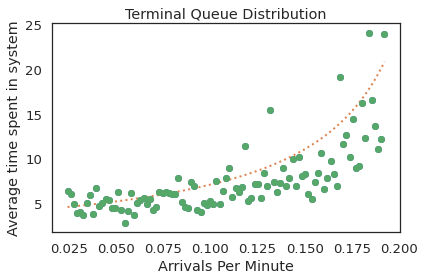

In [261]:
plot(sweep, 'o')
decorate(xlabel = 'Late Arrivals Per Minute',
         ylabel = 'Average time spent in system',
         title = 'Terminal Queue Distribution')
def plot_W(lam_array,mu):
  W = 1 / (mu - lam_array)
  plot(lam_array, W, ':')
plot_W(lam_array,mu)
plot(sweep,'o')
decorate(xlabel = 'Arrivals Per Minute',
         ylabel = 'Average time spent in system',
         title = 'Terminal Queue Distribution')

Next, I will incorporate the different terminals, with a single queue.

In [262]:
time_between = DataFrame(columns = ['time_between'],index = trim_long.index)
for i in range(len(trim_long)):
  if i == 0:
    time_between['time_between'][i] = 0
  elif i > 0:
    diff = trim_long['time_hr'][i] - trim_long['time_hr'][i - 1]
    time_between['time_between'][i] = diff
                    
time_between

,time_between
0,0
1,0.333334
2,0.400001
3,0.683333
4,0.249998
...,...
394,0.083335
395,0.016666
396,0.066667
397,0.249998


In [208]:
trim_long['time_between'] = time_between['time_between']


In [116]:
dur_min = DataFrame(columns = ['duration_min'],index = trim_long.index)
time_bet_min = DataFrame(columns = ['time_between_min'],index = trim_long.index)

for i in range(len(trim_long)):
  dur_min['duration_min'][i] = 60*trim_long['duration_hr'][i]
  time_bet_min['time_between_min'][i] = 60*trim_long['time_between'][i]

trim_long['time_between_min'] = time_bet_min['time_between_min']
trim_long['duration_min'] = dur_min['duration_min']
trim_long.head()

,time,decimal_time,duration,decimal_duration,terminal,time_hr,duration_hr,time_between,time_between_min,duration_min
0,0:09,0.006250,1:04,0.045045,G,0.150000,1.081087,0,0,64.865232
1,0:29,0.020139,1:15,0.052705,D,0.483334,1.264927,0.333334,20.000016,75.895632
2,0:53,0.036806,1:17,0.053535,C,0.883334,1.284830,0.400001,24.000048,77.089824
3,1:34,0.065278,1:14,0.051683,C,1.566667,1.240399,0.683333,40.999968,74.423952
4,1:49,0.075694,1:09,0.047988,D,1.816666,1.151717,0.249998,14.999904,69.103008


In [ ]:
def create_system(lam,mu):
  return System(lam = lam, mu=mu,duration = 24*60)

In [211]:
#lam = len(trim_long) / (24*60) #total daily arrivals divided by minutes per day = arr/min

avg_time_between = np.mean(trim_long['time_between_min'])

avg_wait_time = np.mean(trim_long['duration_min'])

lam = 1/avg_time_between
mu = 1/avg_wait_time

#lam = avg_time_between
#mu = avg_wait_time


system = create_system(lam,mu)
system

,values
lam,0.279412
mu,0.011549
duration,1440.000000


### One Queue, Any Terminal

First, I will show what would happen if there were only one terminal available in a day.

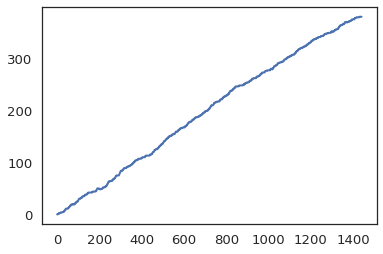

In [212]:
def update_func(waiting,t,system):
  if waiting > 0:
    if flip(system.mu):
      waiting -= 1
  if flip(system.lam):
    waiting += 1
  return waiting

def run_simulation(system,update_func):
  waiting = 0
  result = TimeSeries()
  result[0] = waiting

  for t in linrange(0,system.duration):
    waiting = update_func(waiting,t,system)
    result[t + 1] = waiting
  return result

result = run_simulation(system,update_func)
plot(result)



In short, the line would be worse than the line for gasoline at Costco. It would only grow in size.

One Queue for Ten Terminals

### Ten Queues for Ten Terminals

I will keep the code here for potential future use, but this attempt did not work, and I could not quite understand why.

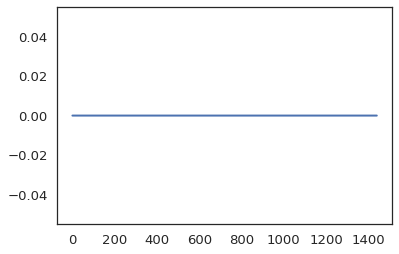

In [213]:
a,b,c,d,e,f,g,h,i,j = 0,0,0,0,0,0,0,0,0,0
def update_func(a,b,c,d,e,f,g,h,i,j,t,system):
  queues = {}
  best_terminal = 'a'
  if a > 0 and flip(system.mu):
    a -= 1
    try:
      queues['a'] = a
    except KeyError:
      queues['a'] = a
  if b > 0 and flip(system.mu):
    b -= 1
    try:
      queues['b'] = b
    except KeyError:
      queues['b'] = b
  if c > 0 and flip(system.mu):
    c -= 1      
    try:
      queues['c'] = c
    except KeyError:
      queues['c'] = c
  if d > 0 and flip(system.mu):
    d -= 1   
    try:
      queues['d'] = d
    except KeyError:
      queues['d'] = d
  if e > 0 and flip(system.mu):
    e -= 1
    try:
      queues['e'] = e
    except KeyError:
      queues['e'] = e
  if f > 0 and flip(system.mu):
    f -= 1
    try:
      queues['f'] = f
    except KeyError:
      queues['f'] = f
  if g > 0 and flip(system.mu):
    g -= 1
    try:
      queues['g'] = g
    except KeyError:
      queues['g'] = g
  if h > 0 and flip(system.mu):
    h -= 1
    try:
      queues['h'] = h
    except KeyError:
      queues['h'] = h
  if i > 0 and flip(system.mu):
    i -= 1
    try:
      queues['i'] = i
    except KeyError:
      queues['i'] = i
  if j > 0 and flip(system.mu):
    j -= 1
    try:
      queues['j'] = j
    except KeyError:
      queues['j'] = j

  if flip(system.lam):
      shortest_line = min([a,b,c,d,e,f,g,h,i,j])
      for i in queues:
        if queues[i] <= shortest_line:
          shortest_line = queues[i]
          best_terminal = i
        if best_terminal == 'a':
          a +=1
        elif best_terminal == 'b':
          b +=1       
        elif best_terminal == 'c':
          c +=1 
        elif best_terminal == 'd':
          d +=1 
        elif best_terminal == 'e':
          e +=1 
        elif best_terminal == 'f':
          f +=1 
        elif best_terminal == 'g':
          g +=1 
        elif best_terminal == 'h':
          h +=1 
        elif best_terminal == 'i':
          i +=1 
        else:
          j +=1 
  return a,b,c,d,e,f,g,h,i,j


def run_simulation(system,update_func):
  a,b,c,d,e,f,g,h,i,j = 0,0,0,0,0,0,0,0,0,0
  results = TimeSeries()
  results[0] = a + b + c + d + e + f + g + h + i + j

  for t in linrange(0,system.duration):
    a,b,c,d,e,f,g,h,i,j = update_func(a,b,c,d,e,f,g,h,i,j,t,system)
    results[t + 1] = a + b + c + d + e + f + g + h + i + j
  return results

result = run_simulation(system,update_func)
plot(result)

# Simulation of One Queue for all Terminals

I will use SimPy now to produce a discrete event simulation for the ten different terminals.

For the purpose of the exercise, I will estimate that it takes 45 minutes to fuel the vehicle after the wait time has elapsed. The time given in the DataFrame is inclusive of wait time and fueling time.

In [206]:
time_frame = TimeFrame(columns = ['vehicle','time_pump_available','time_start',
                                  'time_fuel_start','time_fueling_expected','time_wait','time_exit'])


def new_arrival(environment, time_fueling_expected, terminal, vehicle):

    time_start = environment.now
    time_frame.at[vehicle, 'vehicle'] = vehicle
    time_frame.at[vehicle, 'time_start'] = time_start
    time_frame.at[vehicle, 'time_fueling_expected'] = time_fueling_expected

    with terminal.request() as req:
        
        yield req
        
        time_fueling = environment.now
        time_frame.at[vehicle, 'time_fuel_start'] = time_fueling

        time_wait = (time_fueling - time_start)
        time_frame.at[vehicle, 'time_wait'] = time_wait

        sample_fuel_duration = np.random.exponential(time_fueling_expected) #45 min to fuel
        time_frame.at[vehicle, 'fuel_duration'] = sample_fuel_duration
        
        yield environment.timeout(sample_fuel_duration)

        time_frame.at[vehicle, 'time_exit'] = environment.now

def terminal_activity(environment,avg_time_between,time_fueling_expected,terminal):

    vehicle = 0
    
    while True:
        
        arr = new_arrival(environment, time_fueling_expected, terminal, vehicle)
        environment.process(arr)
        time_between = np.random.exponential(avg_time_between)        

        yield environment.timeout(time_between)

        vehicle += 1


def run_simulation(terminals, avg_time_between, time_fueling_expected):
  environment = simpy.Environment()

  np.random.seed(34)
  terminal = simpy.Resource(environment, capacity = terminals)
  time_between = avg_time_between
  time_fueling_expected = time_fueling_expected
  
  environment.process(terminal_activity(environment, avg_time_between, time_fueling_expected, terminal))

  environment.run(until=24*60)
    
  for vehicle in range(len(time_frame)):
    if time_frame.at[vehicle,'vehicle'] == 0:
      time_frame.at[vehicle, 'time_pump_available'] = 0
    elif time_frame.at[vehicle, 'time_start'] - time_frame.at[vehicle-1, 'time_exit'] < 0:
      time_frame.at[vehicle, 'time_pump_available'] = 0
    else:
      time_frame.at[vehicle, 'time_pump_available'] = time_frame.at[vehicle, 'time_start'] - time_frame.at[vehicle-1, 'time_exit']

  return time_frame
        

In [207]:
run_simulation(10,avg_time_between,45)

,vehicle,time_pump_available,time_start,time_fuel_start,time_fueling_expected,time_wait,time_exit,fuel_duration
0,0,0,0,0,45,0,68.156301,68.156301
1,1,0,0.140742,0.140742,45,0.0,45.23529,45.094548
2,2,0,0.488924,0.488924,45,0.0,124.299782,123.810858
3,3,0,0.538987,0.538987,45,0.0,13.67025,13.131262
4,4,0,2.529337,2.529337,45,0.0,26.642303,24.112967
...,...,...,...,...,...,...,...,...
381,381,NaN,1424.816029,NaN,45,NaN,NaN,NaN
382,382,NaN,1429.113451,NaN,45,NaN,NaN,NaN
383,383,NaN,1429.554028,NaN,45,NaN,NaN,NaN
384,384,NaN,1434.421675,NaN,45,NaN,NaN,NaN


## Model Validation



## Model Verification



### Curiosity: Can the SIR Model be implemented?

Similar the SIR model, I will construct a DWF (Driving, Waiting, Fueled) model. 

A very important assumption must be made, and that is, how long is a driver expected to be driving before entering the queue to fill the vehicle? 

If we assume that all drivers begin driving at midnight, then the expected driving duration would be twelve hours. If we assume that the first thing a driver does to begin the day is visit the fuel terminal, then we have two options. Either each driver begins by default in a queue (this will cause the beta to be undefined), or each driver will need to drive from a different location to reach the queue. 

For the purpose of the simulation, I will assume that drivers need to travel an average of 30 minutes to reach the fuel terminal, and the time listed in the dataframe represents their time of departure. I will assume a pseudo-random distribution of travel time to the fuel terminal. The distribution will span from 0 to 60 minutes, and it will be modeled with an exponential distribution. I chose the exponential distribution because it will provide a better fit for elapsed time for a single arrival, while Poisson will provide the rate of arrivals. 


In [215]:
trim_long

,time,decimal_time,duration,decimal_duration,terminal,time_hr,duration_hr,time_between,time_between_min,duration_min
0,0:09,0.006250,1:04,0.045045,G,0.150000,1.081087,0,0,64.865232
1,0:29,0.020139,1:15,0.052705,D,0.483334,1.264927,0.333334,20.000016,75.895632
2,0:53,0.036806,1:17,0.053535,C,0.883334,1.284830,0.400001,24.000048,77.089824
3,1:34,0.065278,1:14,0.051683,C,1.566667,1.240399,0.683333,40.999968,74.423952
4,1:49,0.075694,1:09,0.047988,D,1.816666,1.151717,0.249998,14.999904,69.103008
...,...,...,...,...,...,...,...,...,...,...
394,23:32,0.980556,1:10,0.048706,A,23.533334,1.168944,0.083335,5.000112,70.13664
395,23:33,0.981250,1:18,0.054338,C,23.550000,1.304105,0.016666,0.999936,78.246288
396,23:37,0.984028,1:28,0.061374,C,23.616667,1.472978,0.066667,4.000032,88.378704
397,23:52,0.994444,1:14,0.051735,G,23.866666,1.241652,0.249998,14.999904,74.49912


In [252]:
t_0 = 0
t_end = 24*60
elapsed_time = t_end - t_0

drive_time = np.random.exponential(30,len(trim_long))
trim_long['drive_time'] = drive_time

def pop_hour(df,hour):
  pop = df.apply(lambda df : True
                 if df['time_hr'] >= float(hour) and df['time_hr'] < float(int(hour + 1)) else False, axis = 1)
  num_rows = len(pop[pop == True].index)
  return num_rows

#pop_hour(trim,float(0))
p_0 = pop_hour(trim,float(0))/60 # in minutes

init = State(D = len(trim_long),W = p_0, F = 0) #Assume All vehicles are being driven (This is a potential problem)
init /= sum(init)

d_w = np.mean(trim_long['drive_time']*60) #expected time between driving and waiting in minutes (hours are in decimal form) 
w_f = np.mean(trim_long['duration_hr']*60) #expected time between waiting and being refueled in minutes

beta = 1/ avg_time_between
gamma = 1/ w_f

def create_system(beta,gamma):
  init = State(D = len(trim_long),W  = p_0, F = 0)
  init /= sum(init)
  t_0 = 0
  t_end = 24*60
  return System(init = init, t_0 = t_0, t_end = t_end, beta = beta, gamma = gamma)

p_end = pop_hour(trim,float(24))/60

def update_func(state, t, system):
  d,w,f = state

  waiting = system.beta * d * w
  fueled = system.gamma * w

  d -= waiting
  w += (waiting - fueled)
  f += fueled

  return State(D=d, W=w, F=f) 


system = create_system(beta,gamma)
state = update_func(init,0,system)
state

def run_simulation(system, update_func):
  frame = TimeFrame(columns = system.init.index)
  frame.row[system.t_0] = system.init
  for t in linrange(system.t_0, system.t_end):
    frame.row[t + 1] = update_func(frame.row[t],t,system)
  return frame

system = create_system(beta,gamma)
result = run_simulation(system,update_func)
result


,D,W,F
0,9.998747e-01,1.252976e-04,0.000000
1,9.998397e-01,1.588557e-04,0.000001
2,9.997953e-01,2.014002e-04,0.000003
3,9.997391e-01,2.553362e-04,0.000006
4,9.996677e-01,3.237127e-04,0.000009
...,...,...,...
1436,5.329074e-12,8.821248e-08,1.000000
1437,5.329074e-12,8.719371e-08,1.000000
1438,5.329074e-12,8.618671e-08,1.000000
1439,5.329074e-12,8.519133e-08,1.000000


### Plot of DWF Model

If all Drivers began heading toward the fuel terminal at the start of the day, the process of fueling all 398 vehicles would be complete rather quickly, with almost no more vehicles left to fuel by 10 AM. 

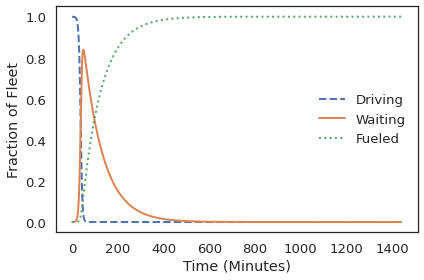

In [253]:
def plot_results(D,W,F):
  plot(D, '--', label='Driving')
  plot(W, '-', label='Waiting')
  plot(F, ':', label='Fueled')
  decorate(xlabel='Time (Minutes)',
           ylabel='Fraction of Fleet')

plot_results(result.D,result.W,result.F)   

### Updating the DWF Model

If we update the DWF model to be more realistic, the time between driving and arriving will need to be updated. In the previous representation, the arrivals at the terminal were modeled similar to disease spread, but realistically, no vehicle arriving at the terminal should be expected to impact another. 

I will use the average number of vehicles arriving in the day, and assume that it is uniformly distributed. 


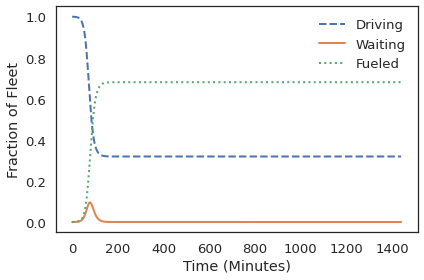

In [254]:
arrivals_per_hour = len(trim_long)/24
time_between_arrivals = 60/arrivals_per_hour #if uniform
fillups_per_hour = 10 #Assuming Each Pump can fill one vehicle per hour
time_between_fillups = 60/fillups_per_hour # if uniform
beta = 1/time_between_arrivals
gamma = 1/time_between_fillups


system = create_system(beta,gamma)
result = run_simulation(system,update_func)
result = run_simulation(system,update_func)
plot_results(result.D,result.W,result.F)   

#### Takeaways from SIR Model Curiosity

The SIR model is not a good way to perform discrete event simulation.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


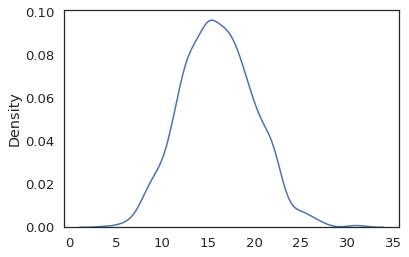

In [229]:
drive_time = np.random.exponential(30,60)
drive_time

from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(random.poisson(np.mean(arrivals['arrivals']),size=1000), hist=False)

plt.show()
